In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import cv2 as cv
plt.rcParams['figure.figsize'] = [15,10]
sns.set_theme()

In [31]:
CYCLIC_COLUMNS = ["PSVTime", "PSV", "PDVTime", "PDV", "EDVTime", "EDV", "ISVTime", "ISV", "MBF1", "MBF2", "SysTime", "DiasTime", "OSI", "WindowTime"]
TIME_SERIES_COLUMNS = ["Time","BloodFlow","Filtered Blood Flow", "Shear", "Filtered Shear", "Velocity", "Diameter"]
ANALYSIS_SETTINGS_COLUMNS = ["Peak Height Threshold", "Cycle Duration", "Peak Count", "EpochEndTime", "Velocity Calibration", "Time Calibration", "Distance Calibration", "Zero Velocity Row Position"]

In [32]:
def subj_file(subj_str: str, trial_type: str, data_type: str):
    folder = f"bloodflow_data/{subj_str}"
    filename = None
    files = None
    
    if trial_type in ['baseline', 'base', 'basline']:
        files = [file_name for file_name in os.listdir(folder) if 'baseline' in file_name or 'basline' in file_name or 'base' in file_name]

    elif trial_type in ['post-oc', 'post-occ', 'post-occlusion', 'post']:
        files = [file_name for file_name in os.listdir(folder) if 'post' in file_name]

    else:
        raise ValueError(f"{trial_type} is not an acceptable parameter for trial_type")
    
    if data_type in ['diameter', 'diam']:
        files = [file_name for file_name in files if 'diam' in file_name]
        filename = files[0][:-4]
    elif data_type in ['time', 'time_series', 'time series', 'cyclic'] :
        files = [file_name for file_name in files if 'flow' in file_name or 'doppler' in file_name]
        filename = files[0][:str.index(files[0], '_')]
        
    else:
        raise ValueError(f"{data_type} is not an acceptable parameter for data_type")
    
    return f"{folder}/{filename}", data_type

In [33]:
def load(file):
    data = pd.DataFrame()
    if file[1] in ['diameter', 'diam']:
        data['diameter'] = np.load(f"{file[0]}.npy")['diameters']
        print(np.load(f"{file[0]}.npy")['px_to_cm'])
        data['diameter'] *= np.load(f"{file[0]}.npy")['px_to_cm']
        
    elif file[1] == 'cyclic':
        data = pd.read_csv(f"{file[0]}_cyclic.csv", header = None)
        data.columns = CYCLIC_COLUMNS
        
    elif file[1] in ['time', 'time_series', 'time series']:
        data = pd.read_csv(f"{file[0]}_time_series.csv", header = None)
        data.columns = TIME_SERIES_COLUMNS
    
    return data

In [34]:
def interpolate(array):
    arr = array.copy()
    
    nan_indices = np.isnan(arr)
    
    if not np.any(nan_indices):
        return array
    valid_indices = np.arange(len(arr))[~nan_indices]
    valid_values = arr[~nan_indices]
    
    spline = sp.interpolate.UnivariateSpline(valid_indices, valid_values, s=0)

    # Interpolate NaN values using the fitted spline
    arr[np.flatnonzero(nan_indices)] = spline(np.flatnonzero(nan_indices))
    
    return arr

In [35]:
def filter_diameter(diameter_series: pd.Series, cutoff_frame=False, apply_median_filter=False):

    print(f"Percent NaN before filtering: {diameter_series.isna().sum() / len(diameter_series) * 100}%")
    
    diameter_array = diameter_series.to_numpy().squeeze()
    
    # Interpolate NaN values
    interpolated_diameter = interpolate(diameter_array.copy())
    
    # Low-pass and high-pass filter parameters
    low_pass_cutoff_frequency = 0.05
    filter_order = 2
    
    # Apply low-pass filter
    lowpass_filter = sp.signal.butter(filter_order, low_pass_cutoff_frequency, 'lowpass', output='sos')
    lowpass_filtered = sp.signal.sosfilt(lowpass_filter, interpolated_diameter)
    
    # Apply high-pass filter
    highpass_filter = sp.signal.butter(filter_order, low_pass_cutoff_frequency, 'highpass', output='sos')
    highpass_filtered = sp.signal.sosfilt(highpass_filter, interpolated_diameter)
    
    # Plot high-pass filtered data before thresholding
    plt.plot(highpass_filtered, label="Before Thresholding", alpha=0.4)
    
    # Calculate deviation and identify outliers
    deviation_threshold = np.std(highpass_filtered) * 0.9
    outlier_mask = (highpass_filtered > deviation_threshold) | (highpass_filtered < -deviation_threshold)
    
    # Exclude the first and last 30 samples to prevent ringing from high pass filtering
    outlier_mask[:30] = False
    outlier_mask[-30:] = False
    
    # Mark indices to be removed, including 1 indices before and after
    removal_mask = np.zeros_like(highpass_filtered, dtype=bool)
    for index in range(len(outlier_mask)):
        if outlier_mask[index]:
            start = max(0, index - 1)
            end = min(len(outlier_mask), index + 2)
            removal_mask[start:end] = True
    
    # Set outliers to NaN
    diameter_array[removal_mask] = np.NaN
    highpass_filtered[removal_mask] = np.NaN
    
    # Plot high-pass filtered data after thresholding
    plt.title("Diameter after High Pass Filtering")
    plt.ylabel("Diameter")
    plt.xlabel("Frame #")
    plt.plot(highpass_filtered, label="After Thresholding")
    plt.axhline(-deviation_threshold, color='r', linestyle='--')
    plt.axhline( deviation_threshold, color='r', linestyle='--')
    plt.legend()
    plt.show()
    
    # Calculate median and threshold for further filtering
    median_diameter = np.nanmedian(diameter_array)
    filtering_threshold = np.nanstd(diameter_array) * 2
    extreme_outlier_mask = (diameter_array > median_diameter + filtering_threshold) | (diameter_array < median_diameter - filtering_threshold)
    
    # Plot original data before setting extreme outliers to NaN
    plt.plot(diameter_array, alpha=0.4, label = "Before Thresholding")
    
    # Set extreme outliers to NaN
    diameter_array[extreme_outlier_mask] = np.NaN
    
    # Plot final diameter after filtering
    plt.title("Diameter after Standard Deviation Band")
    plt.ylabel("Diameter (cm)")
    plt.xlabel("Frame #")
    plt.plot(diameter_array, label = "After Thresholding")
    plt.axhline(median_diameter - filtering_threshold, color='r', linestyle='--')
    plt.axhline(median_diameter + filtering_threshold, color='r', linestyle='--')
    plt.legend()
    plt.show()
    
    # Convert to DataFrame
    diameter_dataframe = pd.DataFrame({"diameter": diameter_array})
    
    print(f"Percent NaN after filtering: {diameter_dataframe.isna().sum() / len(diameter_dataframe) * 100}%")
    
    
    # Apply cutoff frame if specified
    if cutoff_frame:
        diameter_dataframe = diameter_dataframe.iloc[:cutoff_frame]
    
    # Apply median filter if specified
    if apply_median_filter:
        diameter_dataframe = diameter_dataframe.rolling(window=len(diameter_dataframe) // 50, min_periods=1).median()
    
    return diameter_dataframe


In [36]:
subj_no = 8
subj_name = f"ASCI{subj_no:03}"
subj_name

'ASCI008'

# Visualizing Filtering and Signal Processing

In [37]:
baseline = subj_file(subj_name, 'baseline', 'diam')
baseline_diameter = load(baseline)
baseline_comp = baseline_diameter.copy()

0.008403361344537815


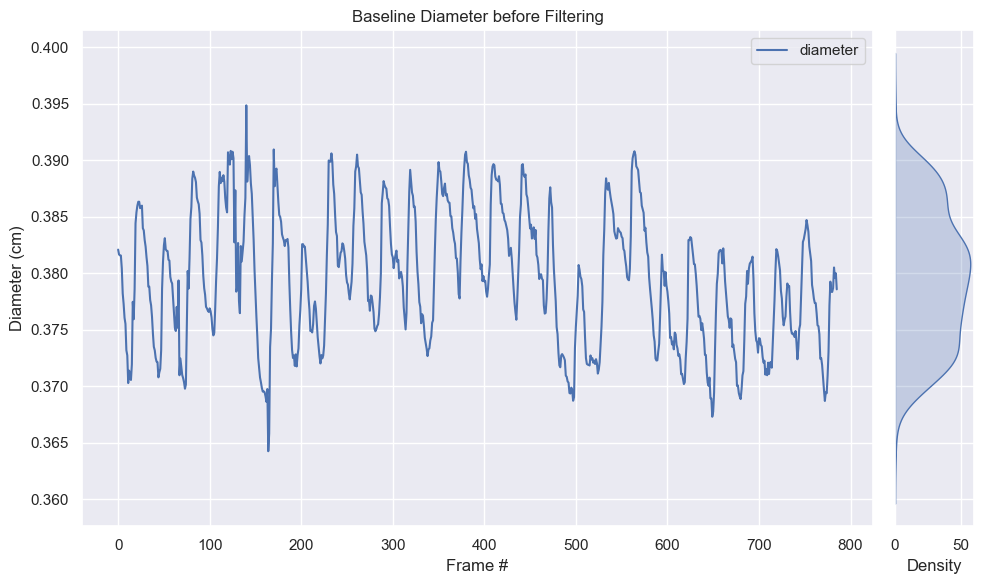

In [38]:
# Create the line plot
fig, ax = plt.subplots(1, 2, width_ratios=[1,0.1], figsize=(10, 6), sharey=True)

sns.lineplot(baseline_diameter, ax = ax[0])
ax[0].set_title("Baseline Diameter before Filtering")
ax[0].set_ylabel("Diameter (cm)")
ax[0].set_xlabel("Frame #")

# Create a secondary axis for the KDE plot
sns.kdeplot(data = baseline_diameter, y = "diameter", ax=ax[1], fill=True)
plt.tight_layout()
plt.show()

Percent NaN before filtering: diameter    0.0
dtype: float64%


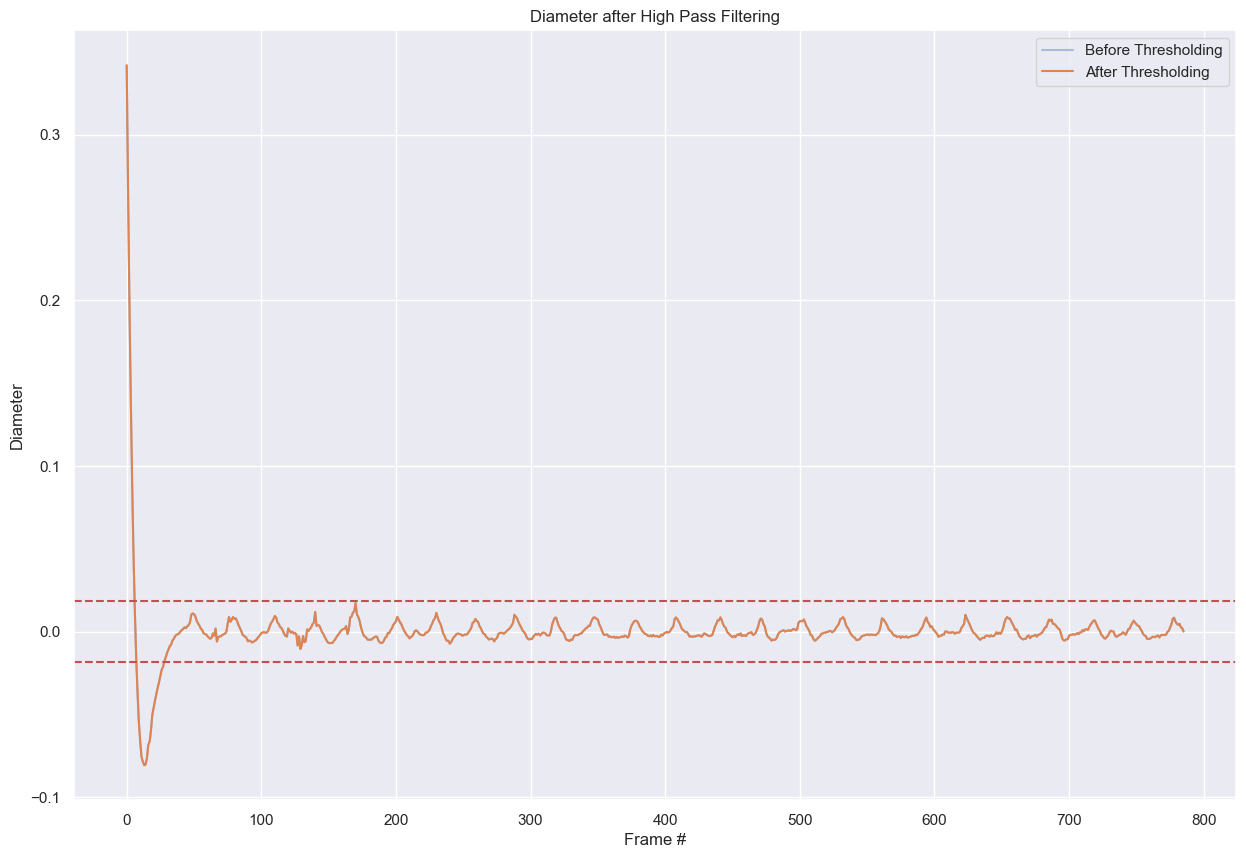

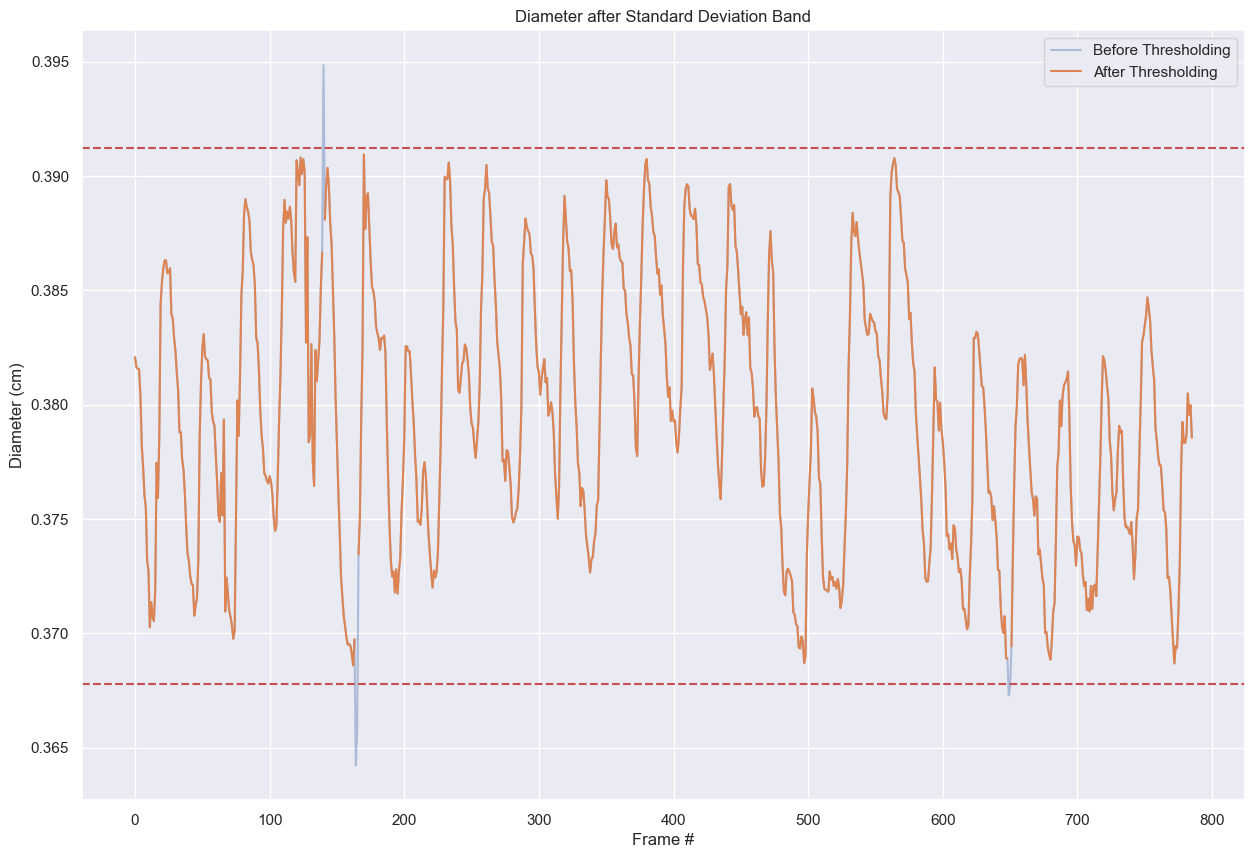

Percent NaN after filtering: diameter    0.636132
dtype: float64%


In [39]:
baseline_diameter = filter_diameter(baseline_diameter)

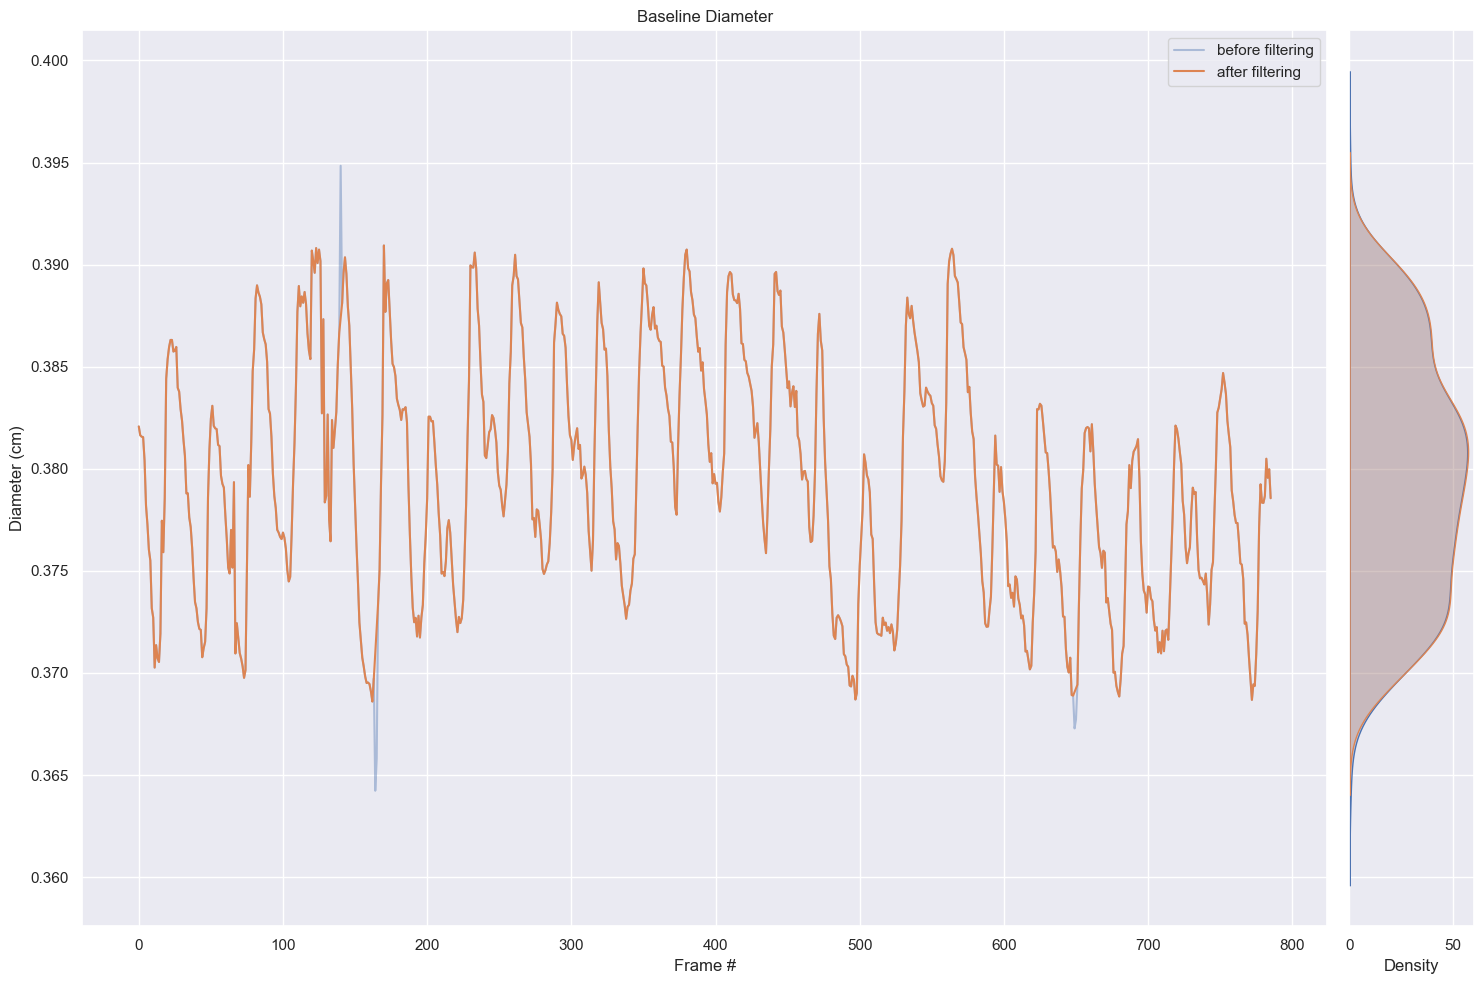

In [40]:
# Create the line plot
fig, ax = plt.subplots(1, 2, width_ratios=[1,0.1], sharey=True)

sns.lineplot(data = baseline_comp, x = baseline_comp.index.values, y = "diameter", ax = ax[0], alpha = 0.4, label = "before filtering")
sns.lineplot(data = baseline_diameter, x = baseline_diameter.index.values, y = "diameter", ax = ax[0], label = "after filtering")
ax[0].set_title("Baseline Diameter")
ax[0].set_ylabel("Diameter (cm)")
ax[0].set_xlabel("Frame #")

# Create a secondary axis for the KDE plot
sns.kdeplot(data = baseline_comp, y = "diameter", ax=ax[1], fill=True)
sns.kdeplot(data = baseline_diameter, y = "diameter", ax=ax[1], fill=True)
plt.tight_layout()
plt.show()

In [41]:
post = subj_file(subj_name, "post-oc", "diam")
post_diameter = load(post)
post_comp = post_diameter.copy()

0.008403361344537815


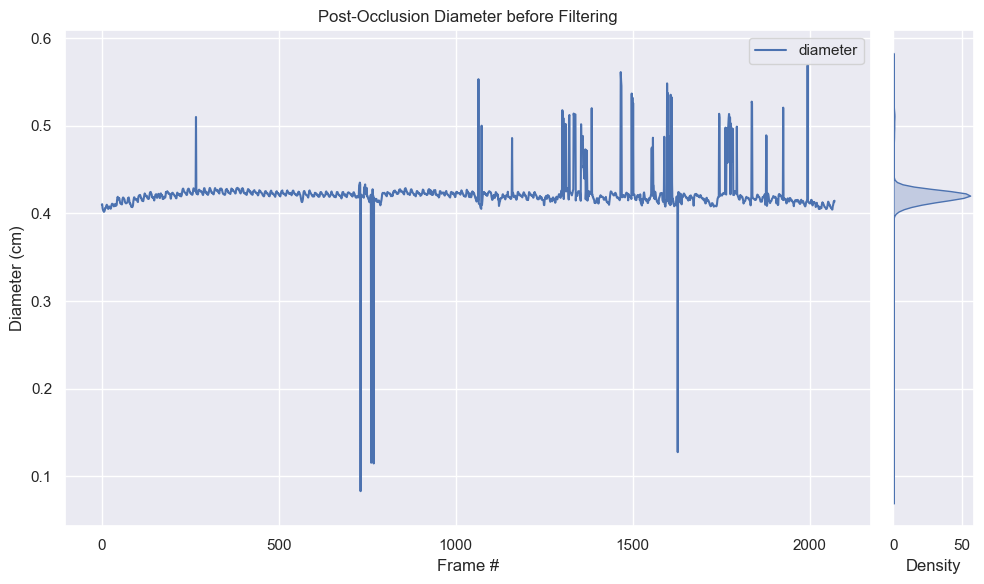

In [42]:
# Create the line plot
fig, ax = plt.subplots(1, 2, width_ratios=[1,0.1], figsize=(10, 6), sharey=True)

sns.lineplot(post_diameter, ax = ax[0])
ax[0].set_title("Post-Occlusion Diameter before Filtering")
ax[0].set_ylabel("Diameter (cm)")
ax[0].set_xlabel("Frame #")

# Create a secondary axis for the KDE plot
sns.kdeplot(data = post_diameter, y = "diameter", ax=ax[1], fill=True)
plt.tight_layout()
plt.show()

Percent NaN before filtering: diameter    0.0
dtype: float64%


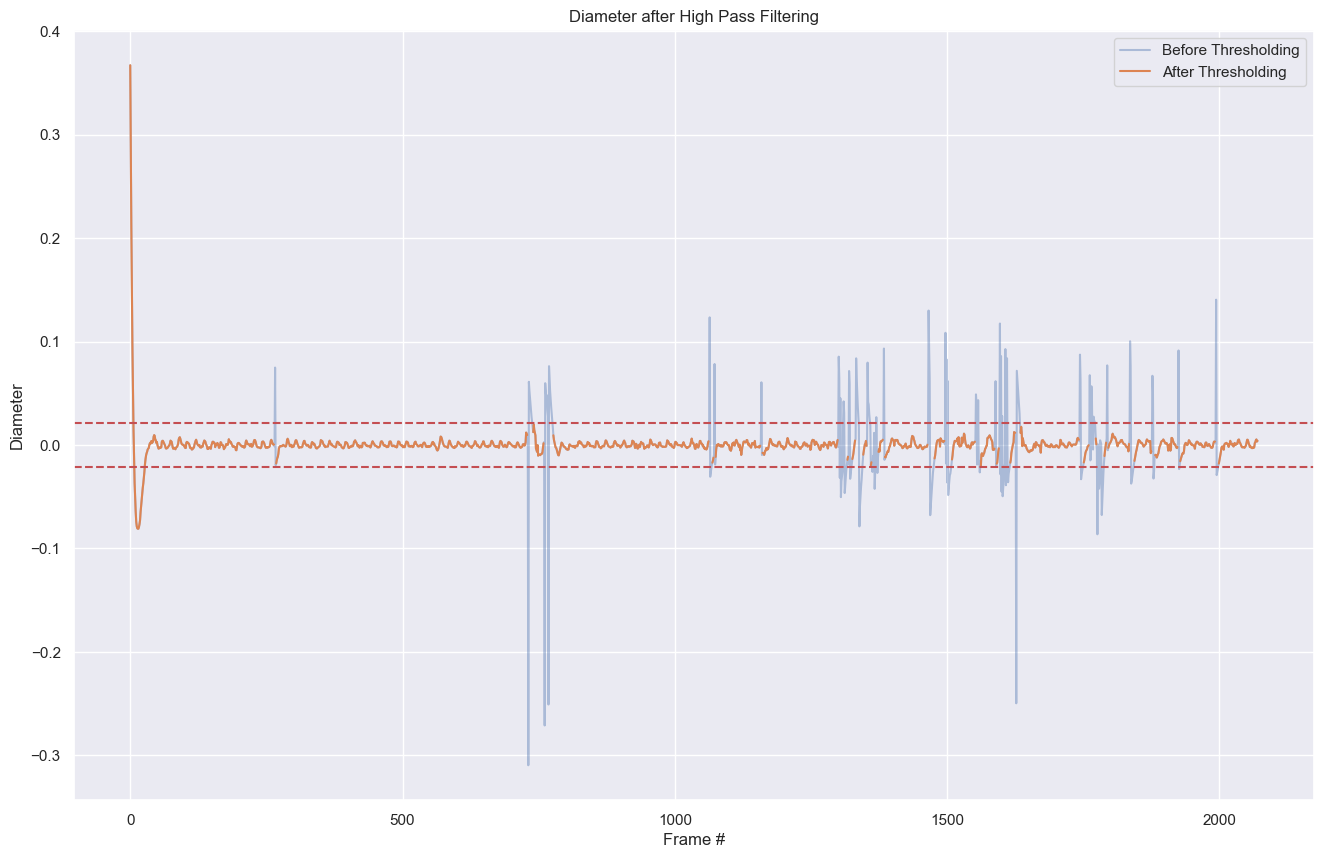

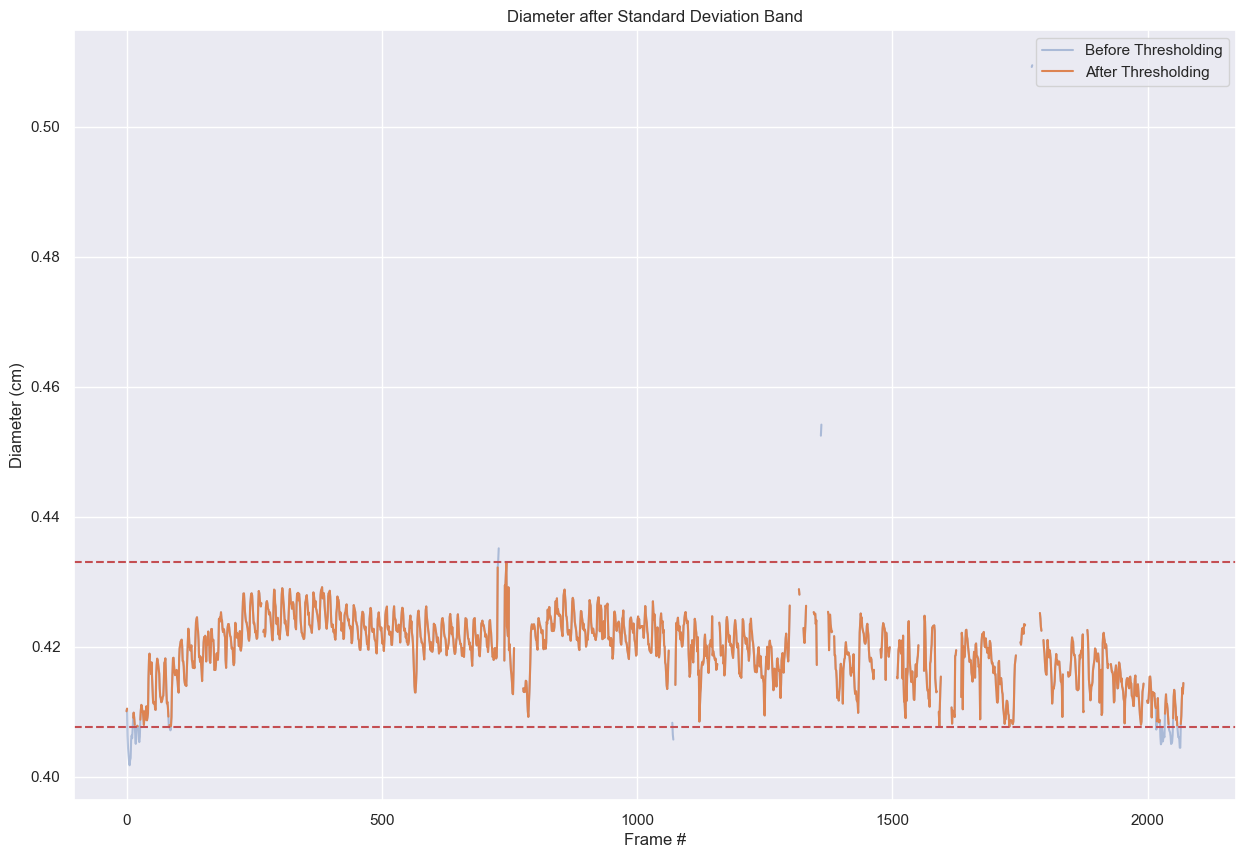

Percent NaN after filtering: diameter    13.713182
dtype: float64%


In [43]:
plt.figure(figsize=(16,10))
post_diameter = filter_diameter(post_diameter)

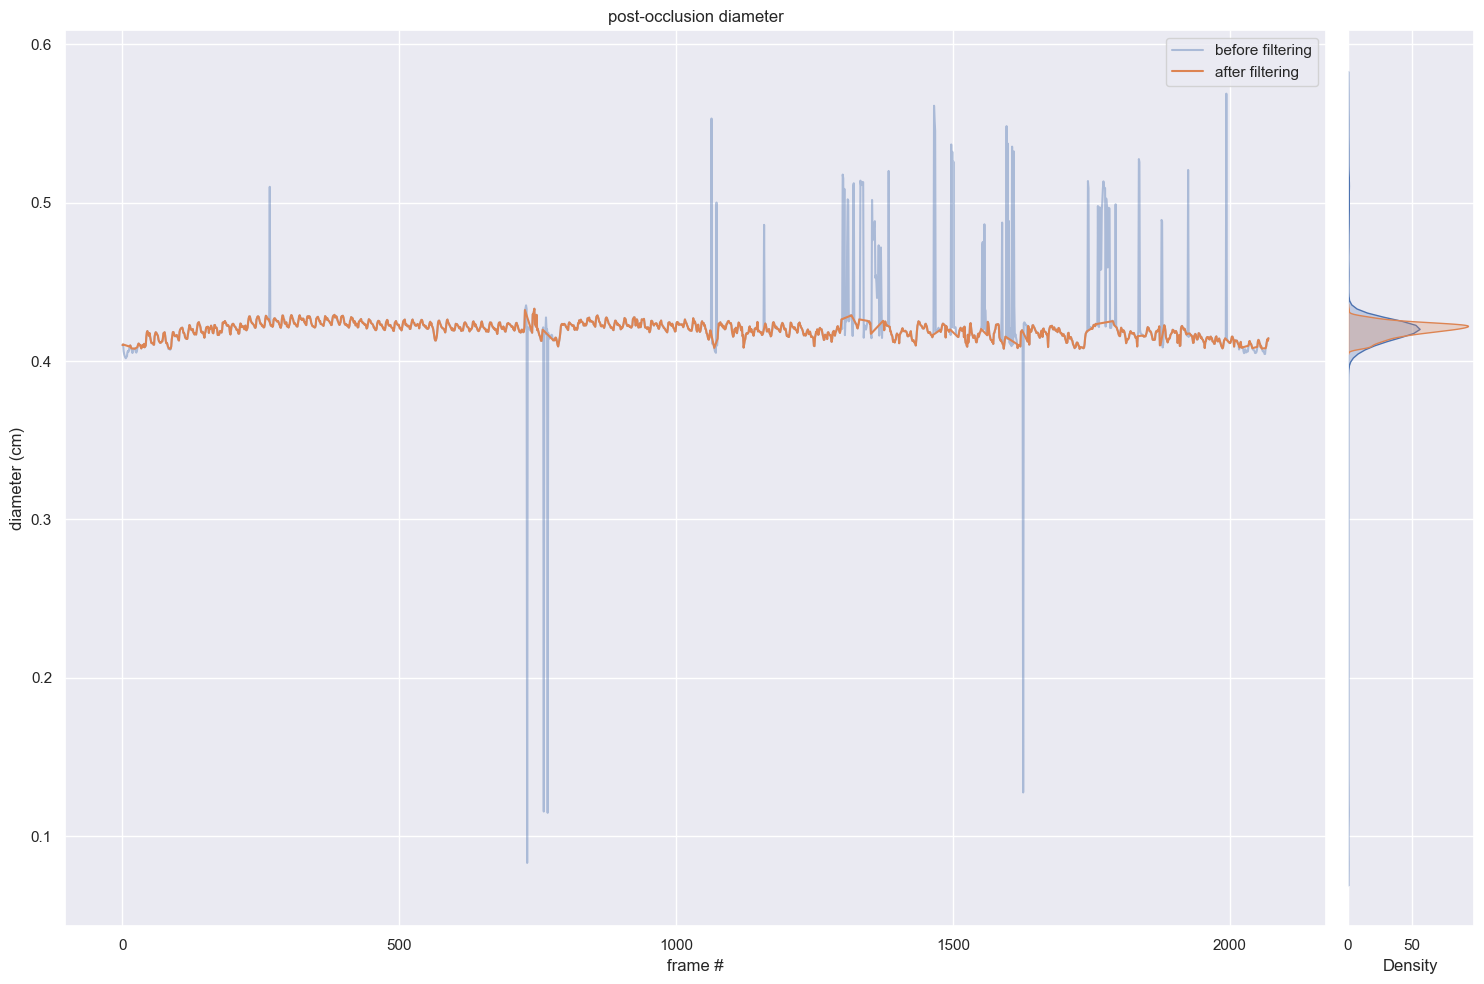

In [44]:
# Create the line plot
fig, ax = plt.subplots(1, 2, width_ratios=[1,0.1], sharey=True)

sns.lineplot(data = post_comp, x = post_comp.index.values, y = "diameter", ax = ax[0], alpha = 0.4, label = "before filtering")
sns.lineplot(data = post_diameter, x = post_diameter.index.values, y = "diameter", ax = ax[0], label = "after filtering")
ax[0].set_title("post-occlusion diameter")
ax[0].set_ylabel("diameter (cm)")
ax[0].set_xlabel("frame #")

# Create a secondary axis for the KDE plot
sns.kdeplot(data = post_comp, y = "diameter", ax=ax[1], fill=True)
sns.kdeplot(data = post_diameter, y = "diameter", ax=ax[1], fill=True)
plt.tight_layout()
plt.show()

# Time Alignment for Data

In [45]:
def get_time(subj_file):
    beginning = str.rfind(subj_file[0], ' ') +1
    time = subj_file[0][beginning+8:]
    hours = int(time[:2])
    mins = int(time[2:4])
    seconds = int(time[4:6])
    miliseconds = float(f"0.{time[6:]}")
    
    time  = (hours*60*60) + mins*60 + seconds + miliseconds
    
    return time

I forgot to add in the time parameters, and the frame rates of the videos for diameter are different, so I'll use OpenCV to correct this

In [46]:
def align_time(subj_data, subj_file, baseline_file = False):
    if subj_file[1] in ['diameter', 'diam']:
        def get_video_fps(subj_file):
            def diam_video_file(subj_file):
                beginning = str.rindex(subj_file[0], '/') + 1
                filename = "raw_video/" + subj_file[0][beginning:] + ".avi"
                return filename
        
            diam_video_file(subj_file)
            video = cv.VideoCapture(diam_video_file(subj_file))
            fps = video.get(cv.CAP_PROP_FPS)
            return 1 / fps
        subj_data['time'] = subj_data.index.values * get_video_fps(subj_file)
        
        if baseline_file != False:
            subj_data['time'] += (get_time(subj_file) - get_time(baseline_file))
        
    elif subj_file[1] in ['time', 'time_series', 'time series']: 
        if baseline_file != False:
            subj_data['Time'] += (get_time(subj_file)- get_time(baseline_file))
        else:
            raise ValueError("To align time series data, a baseline file must be provided.")

In [47]:
align_time(baseline_diameter, baseline)
align_time(post_diameter, post, baseline)

# Diameter Plot

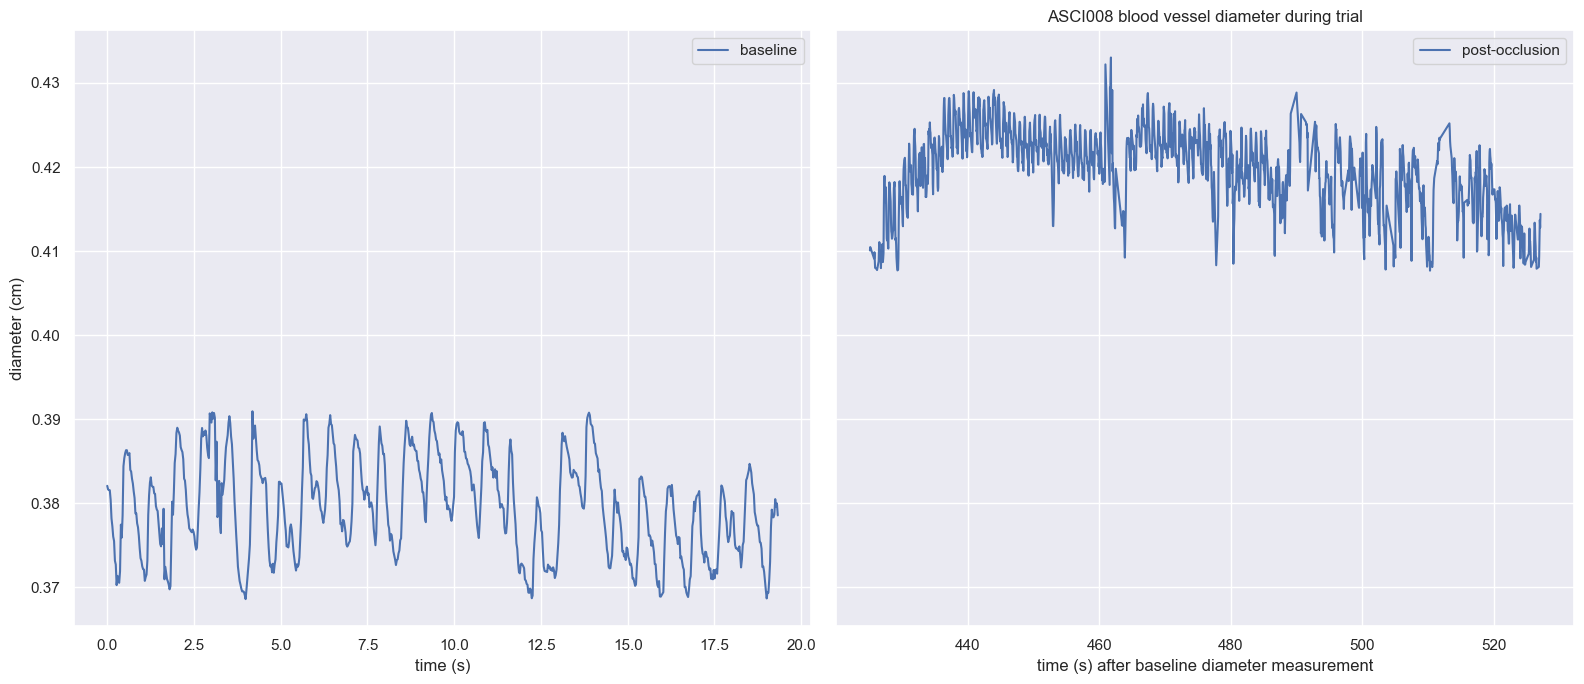

In [48]:
fig, ax = plt.subplots(1, 2, figsize = (16,7), sharey = True, width_ratios=[1,1])
sns.lineplot(ax=ax[0], data = baseline_diameter, x = "time", y = "diameter", label = "baseline")
sns.lineplot(ax=ax[1], data = post_diameter, x = "time", y = "diameter", label = "post-occlusion")

ax[0].set_ylabel("diameter (cm)")
ax[0].set_xlabel("time (s)")

ax[1].set_xlabel("time (s) after baseline diameter measurement")

plt.title(f"{subj_name} blood vessel diameter during trial")
plt.tight_layout()
plt.show()


# Flow-Mediated Dilation Calculation

In [49]:
def get_peaks(diameter: pd.Series, baseline: bool, plot = False):
    diameter_array = diameter.to_numpy().flatten()
    
    if not baseline:
        diameter_array = diameter_array[:len(diameter_array)//2]
    
    peaks = sp.signal.find_peaks(diameter_array, width = 1, height = np.nanmean(diameter_array), prominence= 0.003)[0]
    
    if not baseline:
        moving_peaks = pd.Series(diameter_array[peaks]).rolling(window = 5, center = True).mean()
        peak_choices = peaks.copy()
        
        peak_max_index = moving_peaks.argmax()
        lower = max(0, peak_max_index-2)
        upper = min(len(peaks), peak_max_index+3)
        peaks = peaks[lower:upper]

        if plot: 
            sns.lineplot(diameter_array)
            sns.scatterplot(x = peak_choices, y = diameter_array[peak_choices], color = "orange", alpha = 0.7)
            sns.scatterplot(x = peaks, y = diameter_array[peaks], color = "fuchsia", alpha = 0.5)
            plt.show()
            
    else:
        if plot:
            sns.lineplot(diameter_array)
            sns.scatterplot(x = peaks, y = diameter_array[peaks], color = "fuchsia", alpha = 0.5, s= 200)
            plt.show()
    return peaks 

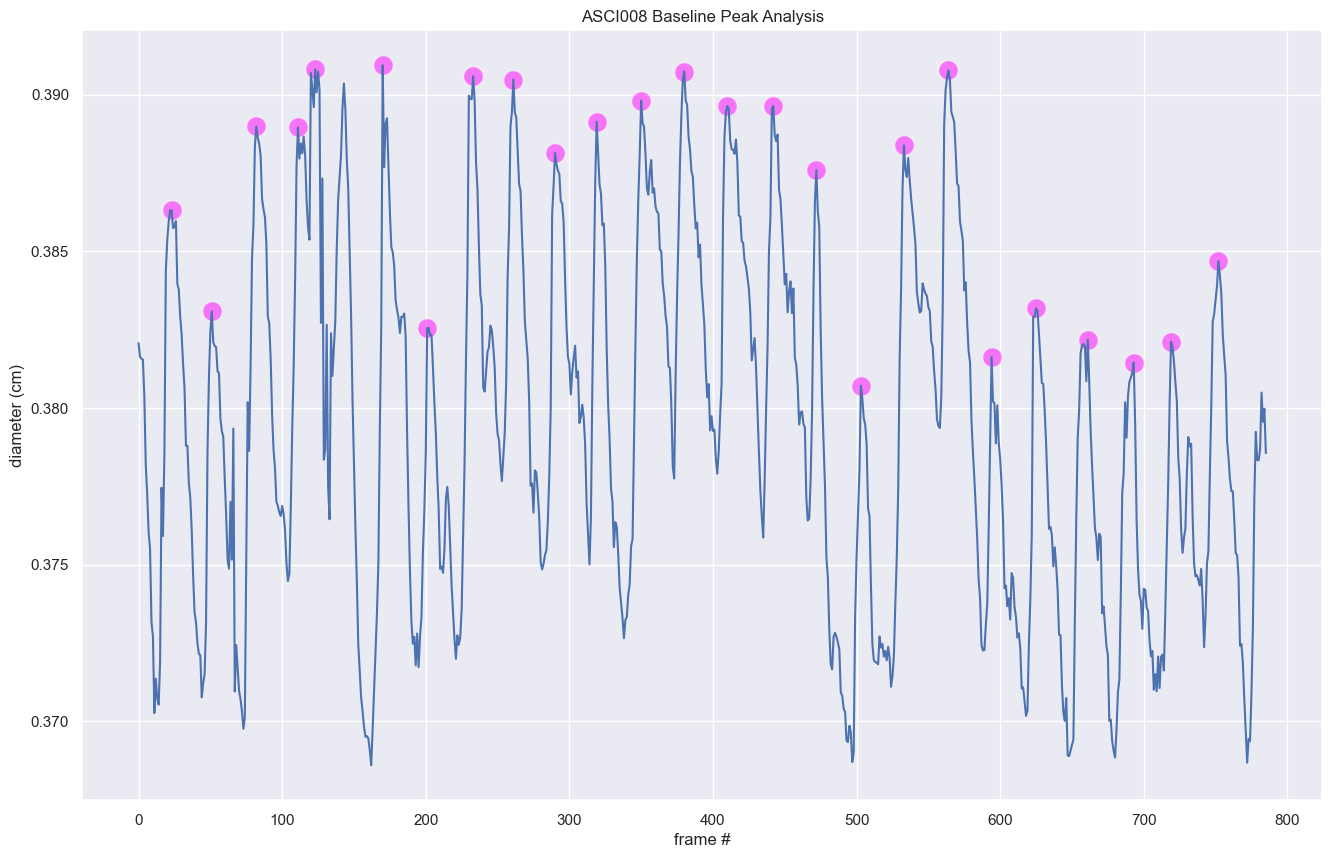

In [50]:
plt.figure(figsize=(16,10))
plt.title(f"{subj_name} Baseline Peak Analysis")
plt.xlabel("frame #")
plt.ylabel("diameter (cm)")
baseline_peaks = get_peaks(baseline_diameter['diameter'], baseline = True, plot = True)


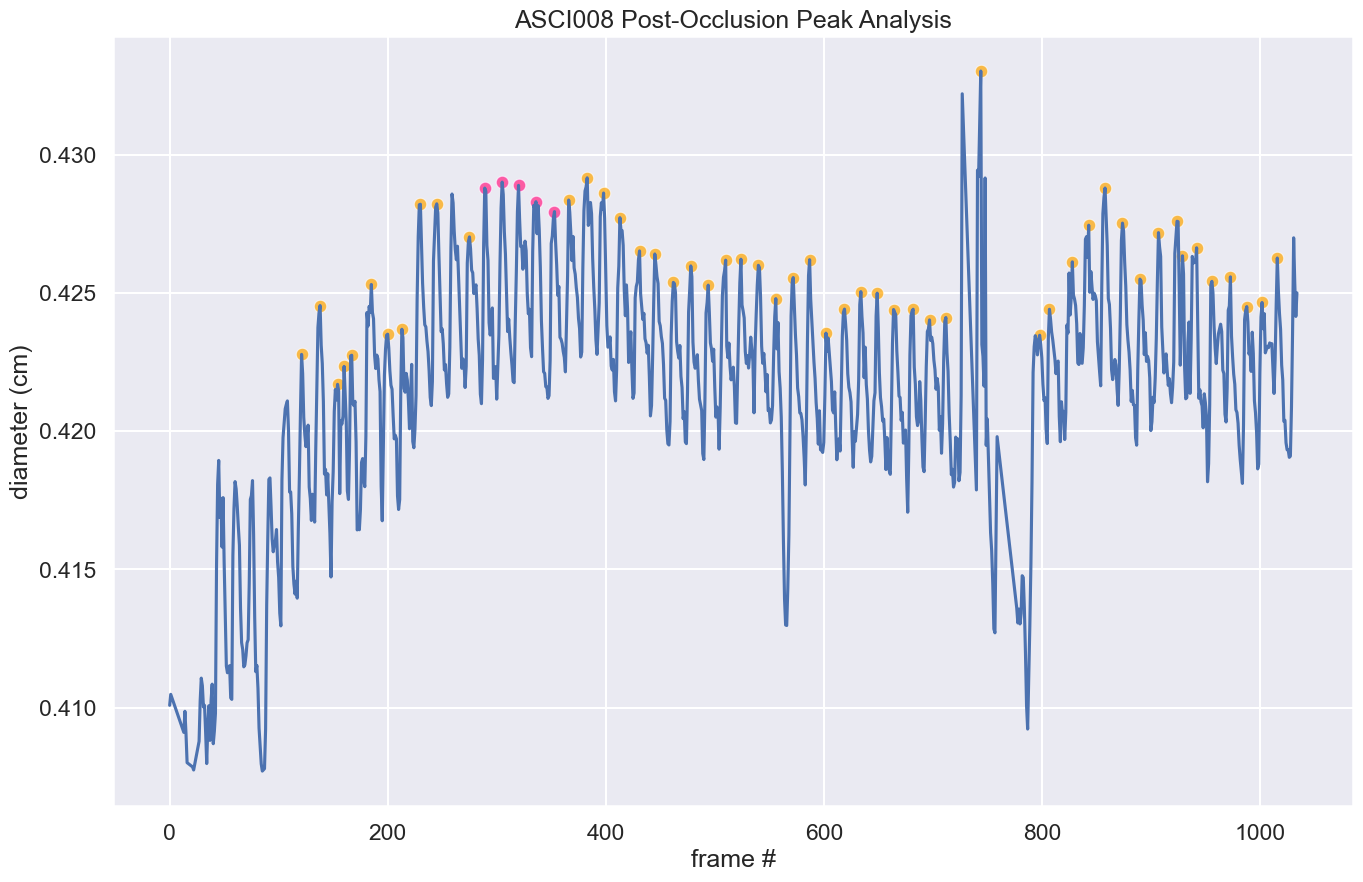

In [51]:
sns.set_context("talk")
plt.figure(figsize=(16, 10))
plt.title(f"{subj_name} Post-Occlusion Peak Analysis")
plt.xlabel("frame #")
plt.ylabel("diameter (cm)")
post_peaks = get_peaks(post_diameter['diameter'], baseline = False, plot = True)

In [52]:
baseline_fmd = baseline_diameter["diameter"].iloc[baseline_peaks].mean()
post_fmd = post_diameter['diameter'].iloc[post_peaks].mean()

In [53]:
post_diameter.iloc[post_peaks]['time']

289    439.339557
305    440.127851
320    440.866877
336    441.655171
353    442.492733
Name: time, dtype: float64

In [54]:
post_diameter.iloc[post_peaks]['time'].mean() - post_diameter.iloc[0]['time'].item()

15.795437749421126

In [55]:
base_shear = subj_file(subj_name, 'baseline', 'time')
shear_rate = load(base_shear)
align_time(shear_rate, base_shear, baseline)
shear_rate

,Time,BloodFlow,Filtered Blood Flow,Shear,Filtered Shear,Velocity,Diameter
0,55.632000,0.00,-27.1090,0.00,-40.0200,0.000,0.38597
1,55.642017,0.00,71.7290,0.00,105.8900,0.000,0.38597
2,55.652034,156.01,132.5200,230.31,195.6300,22.223,0.38597
3,55.662051,190.19,164.0700,280.78,242.2100,27.093,0.38597
4,55.672068,199.43,175.1900,294.41,258.6300,28.408,0.38597
...,...,...,...,...,...,...,...
819,63.835900,-150.71,-88.2780,-222.49,-130.3200,-21.468,0.38597
820,63.845900,0.00,-64.7810,0.00,-95.6350,0.000,0.38597
821,63.855900,0.00,-36.5230,0.00,-53.9180,0.000,0.38597
822,63.866000,0.00,-5.8056,0.00,-8.5706,0.000,0.38597


In [56]:
post_shear = subj_file(subj_name, 'post', 'time')
shear_rate = load(post_shear)
align_time(shear_rate, post_shear, baseline)
shear_rate

,Time,BloodFlow,Filtered Blood Flow,Shear,Filtered Shear,Velocity,Diameter
0,396.653000,0.000,-38.396,0.00,-56.683,0.000,0.38597
1,396.663011,0.000,32.889,0.00,48.554,0.000,0.38597
2,396.673021,0.000,90.746,0.00,133.970,0.000,0.38597
3,396.683032,206.840,135.990,305.35,200.760,29.464,0.38597
4,396.693043,206.840,169.450,305.35,250.160,29.464,0.38597
...,...,...,...,...,...,...,...
1642,413.090000,87.811,138.380,129.63,204.290,12.508,0.38597
1643,413.100000,275.010,220.670,405.98,325.770,39.174,0.38597
1644,413.110000,339.730,310.360,501.53,458.170,48.394,0.38597
1645,413.120000,445.920,401.480,658.29,592.690,63.520,0.38597


# Final Plot

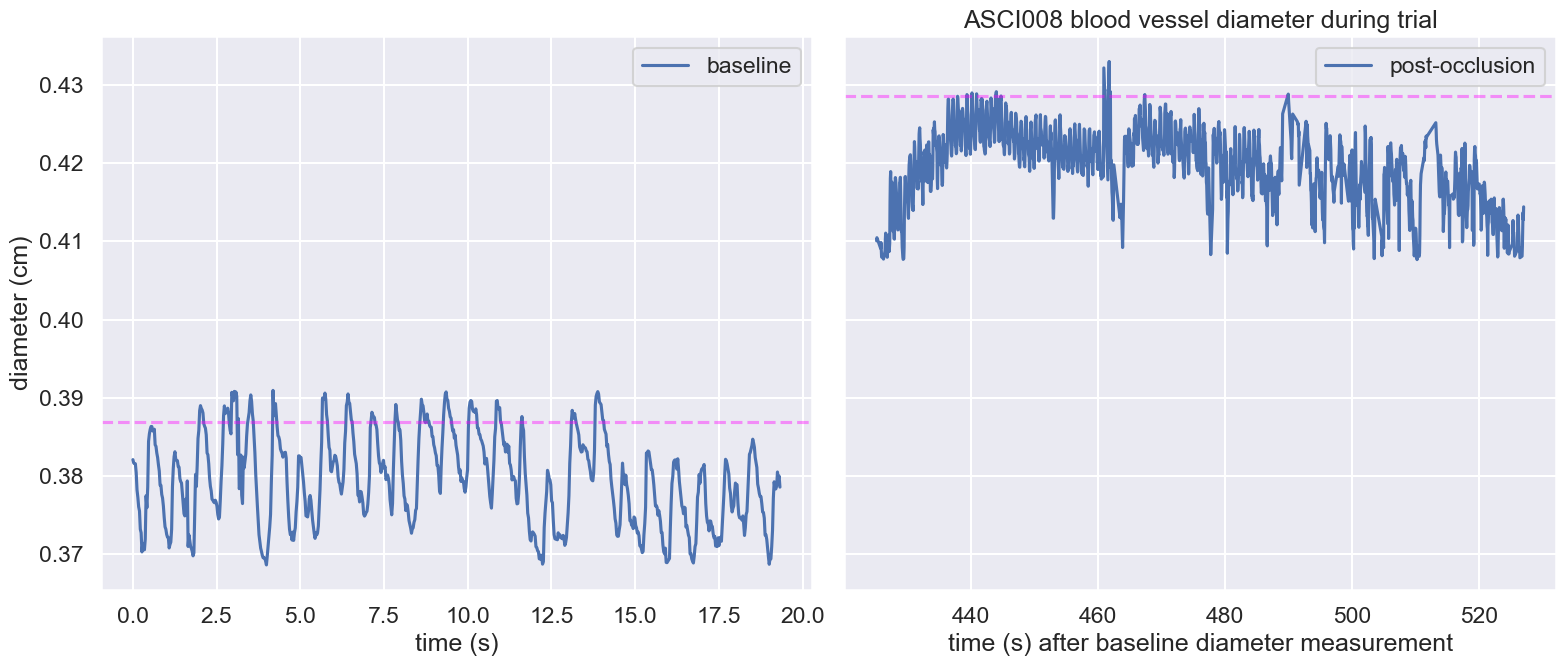

In [57]:
fig, ax = plt.subplots(1, 2, figsize = (16,7), sharey = True, width_ratios=[1,1])
sns.lineplot(ax=ax[0], data = baseline_diameter, x = "time", y = "diameter", label = "baseline")
sns.lineplot(ax=ax[1], data = post_diameter, x = "time", y = "diameter", label = "post-occlusion")

ax[0].set_ylabel("diameter (cm)")
ax[0].set_xlabel("time (s)")

ax[1].set_xlabel("time (s) after baseline diameter measurement")

ax[0].axhline(y = baseline_fmd, alpha = 0.4, linestyle = '--', color = "fuchsia")
ax[1].axhline(y = post_fmd, alpha = 0.4, linestyle = '--', color = "fuchsia")

plt.title(f"{subj_name} blood vessel diameter during trial")
plt.tight_layout()
plt.show()


In [58]:
fmd = (post_fmd - baseline_fmd) / baseline_fmd

print(f"FMD: {fmd * 100:.2f}%")

FMD: 10.77%
